Loaded data:
Train: (2400, 25) | Test: (600, 25)
RandomForest -> Test F1: 0.5125 | Test Acc: 0.5450 | ROC AUC: 0.5295342312008978
ExtraTrees -> Test F1: 0.4867 | Test Acc: 0.5033 | ROC AUC: 0.49823793490460155
XGBoost -> Test F1: 0.5027 | Test Acc: 0.5250 | ROC AUC: 0.528226711560045
LightGBM -> Test F1: 0.5094 | Test Acc: 0.5200 | ROC AUC: 0.5229629629629629
CatBoost -> Test F1: 0.5270 | Test Acc: 0.5450 | ROC AUC: 0.534949494949495

📊 FINAL BENCHMARK RESULTS:

              Train_F1   Test_F1  Test_Accuracy  Test_Precision  Test_Recall  \
Model                                                                          
CatBoost      1.000000  0.527015       0.545000        0.533301     0.530808   
RandomForest  1.000000  0.512464       0.545000        0.529244     0.524411   
LightGBM      0.970901  0.509448       0.520000        0.510735     0.510438   
XGBoost       0.955736  0.502720       0.525000        0.509865     0.508923   
ExtraTrees    1.000000  0.486702       0.503333      

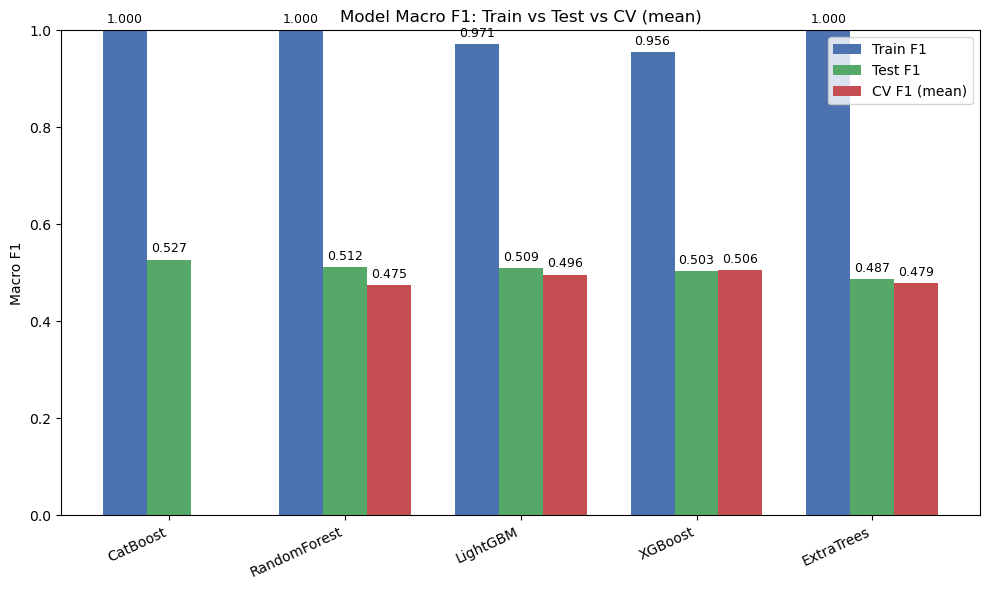

In [1]:
# Full single-cell: imports, data, model evaluation, and plotting

import os
import time
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Silence warnings
warnings.filterwarnings("ignore")
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# ---------------------------
# Base directory paths
# ---------------------------
BASE_DIR = r"C:\Users\uthay\Desktop\CyberThreats_FinancialLoss_Prediction_ML_Project (2)\CyberThreats_FinancialLoss_Prediction_ML_Project"
MODEL_PATH = os.path.join(BASE_DIR, "models")
PROCESSED_PATH = os.path.join(BASE_DIR, "data", "processed")
REPORT_PATH = os.path.join(BASE_DIR, "reports")
os.makedirs(REPORT_PATH, exist_ok=True)

# ---------------------------
# Load data
# ---------------------------
X_train = pd.read_csv(os.path.join(PROCESSED_PATH, "X_train_step4_binary.csv"))
X_test  = pd.read_csv(os.path.join(PROCESSED_PATH, "X_test_step4_binary.csv"))
y_train = np.load(os.path.join(PROCESSED_PATH, "y_train_step4_binary.npy"), allow_pickle=True).astype(int)
y_test  = np.load(os.path.join(PROCESSED_PATH, "y_test_step4_binary.npy"), allow_pickle=True).astype(int)

print("Loaded data:")
print(f"Train: {X_train.shape} | Test: {X_test.shape}")

# ---------------------------
# Models dictionary & CV
# ---------------------------
models = {
    "RandomForest": "RandomForest_step4_binary_prob_tuned.joblib",
    "ExtraTrees": "ExtraTrees_step4_binary_prob_tuned.joblib",
    "XGBoost": "XGBoost_step4_binary_prob_tuned.joblib",
    "LightGBM": "LightGBM_step4_binary_prob_tuned.joblib",
    "CatBoost": "CatBoost_step4_binary_prob_tuned.joblib"
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# ---------------------------
# Evaluate models & collect metrics
# ---------------------------
for name, fname in models.items():
    model_file = os.path.join(MODEL_PATH, fname)
    if not os.path.exists(model_file):
        continue

    model = joblib.load(model_file)

    # Train metrics
    train_preds = model.predict(X_train)
    train_f1 = f1_score(y_train, train_preds, average="macro")

    # Test metrics + inference time
    start = time.time()
    test_preds = model.predict(X_test)
    inference_time = time.time() - start

    test_acc = accuracy_score(y_test, test_preds)
    test_f1 = f1_score(y_test, test_preds, average="macro")
    test_prec = precision_score(y_test, test_preds, average="macro", zero_division=0)
    test_rec = recall_score(y_test, test_preds, average="macro", zero_division=0)

    # ROC-AUC for binary
    if hasattr(model, "predict_proba") and len(np.unique(y_test)) == 2:
        try:
            test_probs = model.predict_proba(X_test)[:, 1]
            test_auc = roc_auc_score(y_test, test_probs)
        except Exception:
            test_auc = np.nan
    else:
        test_auc = np.nan

    # CV F1 mean and std
    try:
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1_macro", n_jobs=-1)
        cv_mean, cv_std = float(cv_scores.mean()), float(cv_scores.std())
    except Exception:
        cv_mean, cv_std = np.nan, np.nan

    # Append to results
    results.append({
        "Model": name,
        "Train_F1": float(train_f1),
        "Test_F1": float(test_f1),
        "Test_Accuracy": float(test_acc),
        "Test_Precision": float(test_prec),
        "Test_Recall": float(test_rec),
        "ROC_AUC": float(test_auc) if not np.isnan(test_auc) else np.nan,
        "CV_F1_Mean": cv_mean,
        "CV_F1_Std": cv_std,
        "Inference_Time_sec": float(inference_time),
        "Inference_Time_per_sample_sec": float(inference_time / max(1, len(X_test)))
    })

    print(f"{name} -> Test F1: {test_f1:.4f} | Test Acc: {test_acc:.4f} | ROC AUC: {test_auc if not np.isnan(test_auc) else 'N/A'}")

# ---------------------------
# Save results summary
# ---------------------------
if results:
    results_df = pd.DataFrame(results).set_index("Model")
    results_df = results_df.sort_values("Test_F1", ascending=False)
    results_file = os.path.join(REPORT_PATH, "classification_model_benchmarking_final.csv")
    results_df.to_csv(results_file)
    print("\n📊 FINAL BENCHMARK RESULTS:\n")
    print(results_df)
    best_model = results_df["Test_F1"].idxmax()
    print(f"\n🏆 Best model based on Test Macro-F1: {best_model}")
else:
    print("No models evaluated.")

# ---------------------------
# Plot Train/Test/CV F1
# ---------------------------
plot_df = results_df[["Train_F1", "Test_F1", "CV_F1_Mean"]].copy()
plot_df = plot_df.sort_values("Test_F1", ascending=False)

models_list = plot_df.index.tolist()
x = np.arange(len(models_list))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width, plot_df["Train_F1"], width, label="Train F1", color="#4C72B0")
ax.bar(x, plot_df["Test_F1"], width, label="Test F1", color="#55A868")
ax.bar(x + width, plot_df["CV_F1_Mean"], width, label="CV F1 (mean)", color="#C44E52")

ax.set_ylabel("Macro F1")
ax.set_title("Model Macro F1: Train vs Test vs CV (mean)")
ax.set_xticks(x)
ax.set_xticklabels(models_list, rotation=25, ha="right")
ax.set_ylim(0, 1.0)
ax.legend(loc="upper right")

# Annotate bars
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f"{height:.3f}", xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


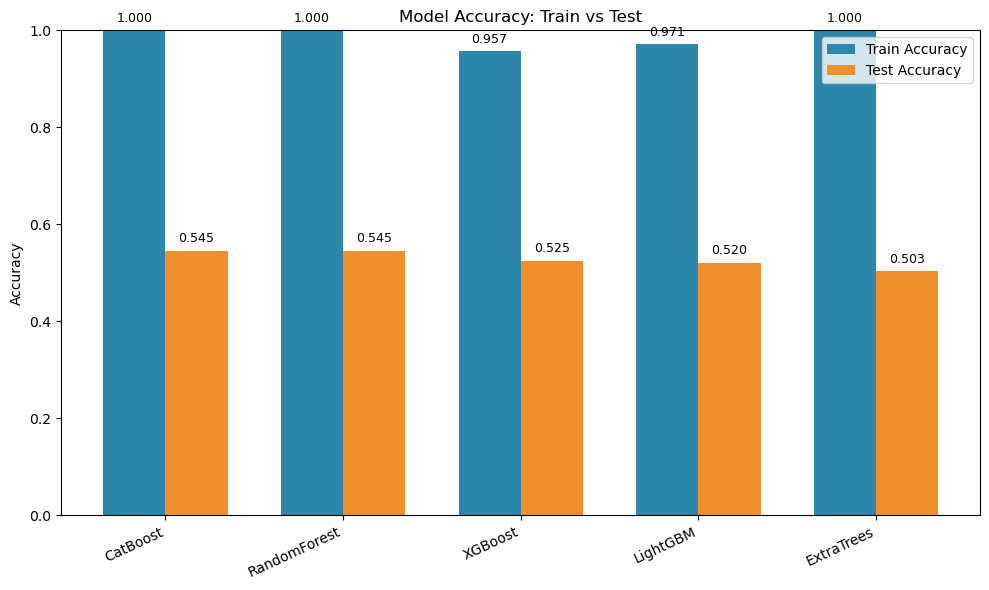

In [2]:
# Cell 7: Train vs Test Accuracy
df = pd.read_csv(os.path.join(REPORT_PATH, "classification_model_benchmarking_final.csv"), index_col="Model")
X_train = pd.read_csv(os.path.join(PROCESSED_PATH, "X_train_step4_binary.csv"))
y_train = np.load(os.path.join(PROCESSED_PATH, "y_train_step4_binary.npy"), allow_pickle=True).astype(int)

train_accs = {}
for model_name, fname in models.items():
    model_path = os.path.join(MODEL_PATH, fname)
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        train_accs[model_name] = float(accuracy_score(y_train, model.predict(X_train)))
    else:
        train_accs[model_name] = np.nan

df["Train_Accuracy"] = pd.Series(train_accs).fillna(df["Test_Accuracy"])
plot_df = df[["Train_Accuracy", "Test_Accuracy"]].sort_values("Test_Accuracy", ascending=False)

x = np.arange(len(plot_df))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, plot_df["Train_Accuracy"], width, label="Train Accuracy", color="#2E86AB")
ax.bar(x + width/2, plot_df["Test_Accuracy"], width, label="Test Accuracy", color="#F28E2B")

ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy: Train vs Test")
ax.set_xticks(x)
ax.set_xticklabels(plot_df.index.tolist(), rotation=25, ha="right")
ax.set_ylim(0,1.0)
ax.legend(loc="upper right")

# Annotate bars
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f"{height:.3f}", xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0,4), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


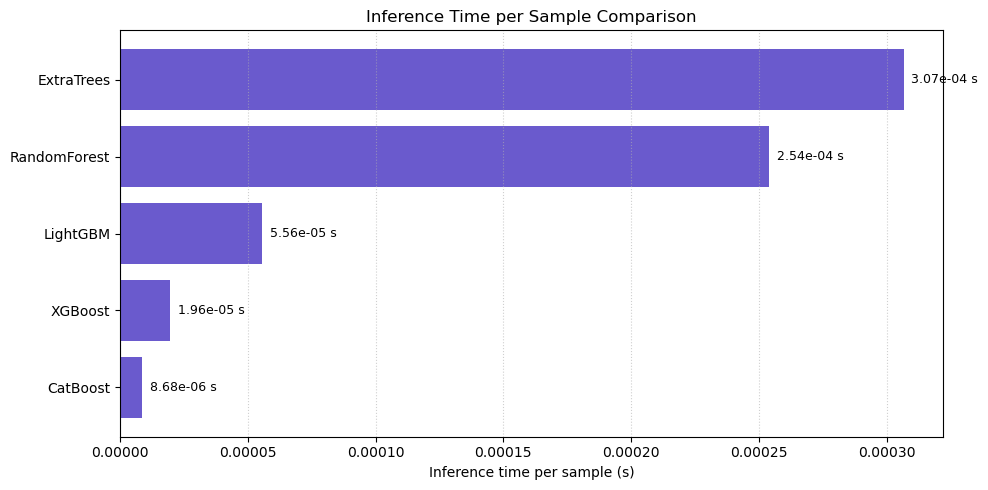

In [3]:
# Cell 8: Inference Time Comparison
df = pd.read_csv(os.path.join(REPORT_PATH, "classification_model_benchmarking_final.csv"), index_col="Model")
df["Inference_Time_per_sample_sec"] = pd.to_numeric(df.get("Inference_Time_per_sample_sec", 0.0), errors="coerce").fillna(0.0)
plot_df = df.sort_values("Inference_Time_per_sample_sec", ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
x = np.arange(len(plot_df))
vals = plot_df["Inference_Time_per_sample_sec"].values
ax.barh(x, vals, color="#6A5ACD")
ax.set_yticks(x)
ax.set_yticklabels(plot_df.index.tolist())
ax.invert_yaxis()
ax.set_xlabel("Inference time per sample (s)")
ax.set_title("Inference Time per Sample Comparison")
ax.grid(axis="x", linestyle=":", alpha=0.6)

for i, v in enumerate(vals):
    label = f"{v:.6f} s" if v >= 0.001 else f"{v:.2e} s"
    ax.text(v + max(vals)*0.01, i, label, va='center', fontsize=9)

plt.tight_layout()
plt.show()


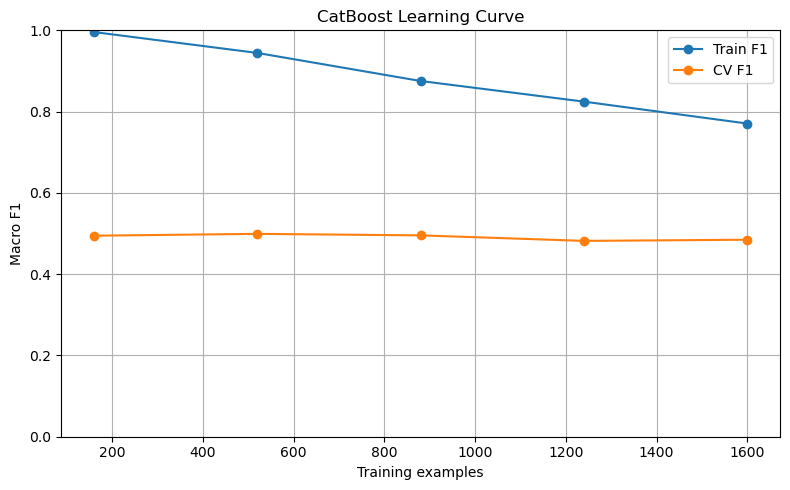

In [7]:
from sklearn.model_selection import StratifiedKFold, learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Create a fresh wrapper
wrapper = CatBoostSklearnWrapper(
    iterations=200, learning_rate=0.03, depth=6, l2_leaf_reg=3.0, random_seed=42, verbose=False
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # smaller CV for speed
train_sizes = np.linspace(0.1, 1.0, 5)

train_sizes, train_scores, val_scores = learning_curve(
    wrapper, X_train, y_train,
    cv=cv, scoring='f1_macro', train_sizes=train_sizes, n_jobs=-1, shuffle=True
)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train F1', color='#1f77b4')
plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='CV F1', color='#ff7f0e')
plt.xlabel('Training examples')
plt.ylabel('Macro F1')
plt.title("CatBoost Learning Curve")
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
